# Code Sandbox

A place to test new code and functions

In [1]:
# import packages and set working directory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
import seaborn as sns

#os.chdir('../maize-Toff')

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import make_climate_parameters, average_soil_moisture

In [2]:
climate = Climate(station='OL JOGI FARM')

soil = Soil(texture='loam')
crop = Crop(soil=soil, lgp=180)
soil.set_nZr(crop)

model = CropModel(crop=crop, climate=climate, soil=soil)
model.run()
o = model.output() # This is the correct length

In [3]:
planting_date = 100
s0_mean, s0_std = average_soil_moisture(model, n_sims=500, doy=planting_date)
output = model.run(s0=s0_mean, planting_date=planting_date, do_output=True)
#output # This just returns the length of average soil moisture calculation

In [4]:
average_soil_moisture(model, n_sims=1000, doy=90)

(59    0.553367
 dtype: float64, 59    0.078981
 dtype: float64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1193b2f28>]],
      dtype=object)

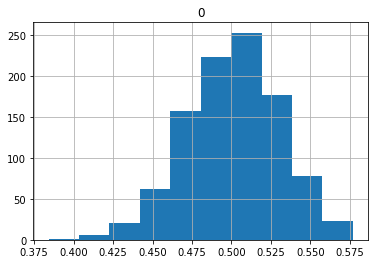

In [107]:
n_sim = 1000
models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

planting_date = 10

output = [model.run(do_output=True, planting_date=planting_date) for model in models]

s_avg = pd.DataFrame([o['s'].mean() for o in output])
s_avg.hist()

## Questions for Kelly: 

### 1. Is this the correct order of operations for running the model:

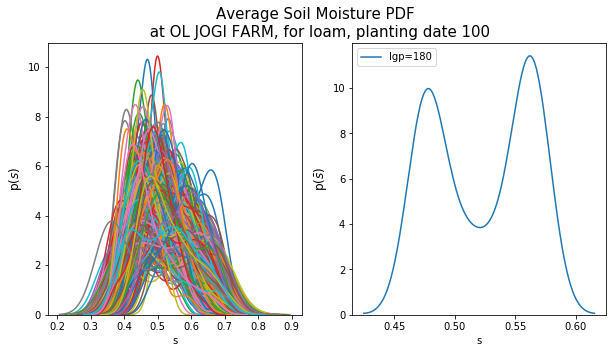

In [115]:
def soil_moisture_pdf(n_sim = 500, pd_ic = 1, station = 'OL JOGI FARM', texture = 'loam', lgp=180, pd_sim=100):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: soil_moisture_pdf(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    n_sim = n_sim # change back to 1000 later
    planting_date = pd_ic # Because we want a date with little rainfall

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]

    # Part 4. Select the planting date we want 
    planting_date = pd_sim
    
    # Part 5. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 6. Subset the growing period and get avg, var soil moisture
    start = 21 # would be nice not to have to hard code this in. TODO. 
    end = start + lgp

    avg_df = pd.concat([df[start:end]['s'] for df in output], axis=1)                          
    avg_df["mean"], avg_df["var"] = avg_df.mean(axis=1), avg_df.var(axis=1)  
    
    # Part 7. Make figures: left is all of the simulations, right is the average
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(10, 5), sharex=False)
    fig.suptitle('Average Soil Moisture PDF \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim, fontsize=15)

    axes[0].set_ylabel(r'p($s$)', fontsize=12)
    axes[1].set_ylabel(r'p($\bar{s}$)', fontsize=12)

    for i in np.arange(n_sim):
        sns.distplot(output[i][start:end]['s'], bins=None, hist=False, kde=True, rug=False, ax=axes[0])

    sns.distplot(avg_df['mean'], bins=None, hist=False, kde=True, rug=False, ax=axes[1], label="lgp=%d" %lgp)
    plt.xlabel('s')

    return plt.show, int(lgp), avg_df, output, start, end

plot, lgp, avg_df, output, start, end = soil_moisture_pdf()

A few tests related to this figure:

In [116]:
# 1. Is the length of the output correct?
print('Is the length of the output the same as the length of growing period?',len(avg_df) == lgp, lgp)

# 2. What is the leakage, rainfall on any given day? -- Need some kind of statement here to test
# Probably related to sfc
sample_leakage = pd.DataFrame([output[100][start:end]['R'],output[100][start:end]['L']]).T
sample_leakage

Is the length of the output the same as the length of growing period? True 180


,R,L
21,0.000000,0.0
22,14.563844,0.0
23,0.000000,0.0
24,0.000000,0.0
25,0.000000,0.0
26,0.000000,0.0
27,0.000000,0.0
28,0.000000,0.0
29,0.000000,0.0
30,0.000000,0.0


### 2. Generate figure with 3 LGPs, 2 climatologies